**Modelo de red neuronal MLP**

Este archivo consta de los codigos y conclusiones de:
* 1.Carga de librerias y datos
* 2.Normalizar Datos.
* 3.Preparar datos para realizar aprendizaje supervizado.
* 4.Modelo MLP
* 5.Evaluacion del modelo


#1.Carga de Librerias y Datos


*Se importan los módulos necesarios para trabajar*

In [89]:
#Pandas es utilizado para leer los set de datos
import pandas as pd
#Numpy es utilizado para generar las series de datos a graficar
import numpy as np
#Seaborn es utilizado para generar los gráficos
import seaborn as sns
import matplotlib.pyplot as plt
#Se importan modulos estadisticos para generar test de hipotesis, entre otros
from sklearn.preprocessing import StandardScaler
#Módulos implementa funciones que evalúan el error de predicción para propósitos específicos
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
#Ignorar warnings
import warnings
warnings.filterwarnings("ignore")

#Dividir arreglos o matrices en subconjuntos aleatorios de tren y prueba
from sklearn.model_selection import train_test_split

#Biblioteca de Redes Neuronales
from keras.models import Sequential,model_from_json
from keras.layers import Dropout, Dense, Activation,Input
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

from hyperopt import Trials, STATUS_OK, tpe, hp, fmin, space_eval
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict, TimeSeriesSplit
import time

In [90]:
# Para acceder a los archivos del gdrive
from google.colab import drive
drive.mount('/content/gdrive/')


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [91]:
cd /content/gdrive/MyDrive/Tesis/Datos-2

/content/gdrive/MyDrive/Tesis/Datos-2


Se obtiene conjunto de datos

In [92]:
df=pd.read_csv('df_EDA.csv',
                parse_dates={'dt':['Date','time']},
                infer_datetime_format=True,
                low_memory=False,
                index_col='dt')

In [93]:
df=df[['Global_active_power','Global_intensity', 'Global_reactive_power', 'Voltage', 'Sub_metering_1', 'Sub_metering_2','Sub_metering_3']]

In [94]:
## resampling of data over hour
df = df.resample('D').mean()

In [95]:
#Setear semilla
np.random.seed(42)

#2.Normalizar base de datos

El **método de puntuación z** (a menudo llamado estandarización ) transforma los datos en una distribución con una media de 0 y una desviación estándar de 1 . Cada valor estandarizado se calcula restando la media de la característica correspondiente y luego dividiendo por la desviación estándar.

In [96]:
#Seleccion de caracteristicas
features =df.columns

#Se define escalado
std_scaler = StandardScaler()

#Transformacion

for i in features:
  df[i] = std_scaler.fit_transform(df[i].values.reshape(-1,1))

In [97]:
print("Normalizacion realizada")

Normalizacion realizada


#3.Preparar datos para realizar aprendizaje supervizado.

La idea es modelar cada valor en función de los valores recientes anteriores, dado un retardo de tiempo dado. **Los valores futuros de una variable en una serie de tiempo dependen de sus propios rezagos y de los rezagos de otras variables.**

In [98]:
def time_delay_embedding(series: pd.Series, n_lags: int, horizon: int):
    """
    Incrustación de retardo de tiempo
    :param series: serie de tiempo como objeto de pandas
    :param n_lags: número de valores pasados para usar como variables explicativas
    :param horizon: horizonte de pronostico
    :return:pd.DataFrame con series temporales reconstruidas
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    serie_time_delay = [series.shift(i) for i in n_lags_iter]
    serie_time_delay = pd.concat(serie_time_delay, axis=1).dropna()
    serie_time_delay.columns = [f'{name}(t-{j - 1})'
                 if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                 for j in n_lags_iter]

    return serie_time_delay

In [99]:
serie_split = []
for columna in df:
  col_df = time_delay_embedding(
      df[columna], #Serie de tiempo
      n_lags=3, #Numero de retrasos
      horizon=1 # Horizonte de prediccion
      )
  serie_split.append(col_df)

In [100]:
serie_df = pd.concat(serie_split, axis=1).dropna()

In [101]:
predictor_variables = serie_df.columns.str.contains('\(t\-')
target_variables = serie_df.columns.str.contains('Global_active_power\(t\+')

In [102]:
predictor_variables = serie_df.iloc[:, predictor_variables]
target_variables = serie_df.iloc[:, target_variables]

In [103]:
predictor_variables.head()

,Global_active_power(t-2),Global_active_power(t-1),Global_active_power(t-0),Global_intensity(t-2),Global_intensity(t-1),Global_intensity(t-0),Global_reactive_power(t-2),Global_reactive_power(t-1),Global_reactive_power(t-0),Voltage(t-2),...,Voltage(t-0),Sub_metering_1(t-2),Sub_metering_1(t-1),Sub_metering_1(t-0),Sub_metering_2(t-2),Sub_metering_2(t-1),Sub_metering_2(t-0),Sub_metering_3(t-2),Sub_metering_3(t-1),Sub_metering_3(t-0)
dt,,,,,,,,,,,,,,,,,,,,,
2007-01-04,2.034827,-0.479665,-0.913282,1.981839,-0.505030,-0.919220,-0.579222,0.254588,0.380838,-0.344607,...,1.328309,-1.006100,-1.006100,-1.006100,-0.715621,-0.717544,-0.719467,-0.877707,-0.698740,-1.170300
2007-01-05,-0.479665,-0.913282,2.902136,-0.505030,-0.919220,2.905632,0.254588,0.380838,0.491035,0.541014,...,-0.529403,-1.006100,-1.006100,-0.344237,-0.717544,-0.719467,2.768191,-0.698740,-1.170300,0.438568
2007-01-06,-0.913282,2.902136,1.974266,-0.919220,2.905632,1.963020,0.380838,0.491035,-0.085215,1.328309,...,-0.165616,-1.006100,-0.344237,-0.072187,-0.719467,2.768191,-0.702637,-1.170300,0.438568,-0.425828
2007-01-07,2.902136,1.974266,-0.073304,2.905632,1.963020,-0.014000,0.491035,-0.085215,0.291083,-0.529403,...,-0.567097,-0.344237,-0.072187,-0.164759,2.768191,-0.702637,-0.691578,0.438568,-0.425828,-0.930715
2007-01-08,1.974266,-0.073304,1.522701,1.963020,-0.014000,1.606520,-0.085215,0.291083,1.356397,-0.165616,...,0.032864,-0.072187,-0.164759,0.245206,-0.702637,-0.691578,3.047088,-0.425828,-0.930715,0.940831


In [104]:
#Se separa conjunto en entrenamiento y prueba; sin aleatoriedad
#Dejando un %30 de la data para test
X_train, X_test, Y_train, Y_test = train_test_split(predictor_variables, target_variables, test_size=0.2, shuffle=False)

shape=len(X_train.columns)

print("Separacion de datos terminada!")

Separacion de datos terminada!


#MLP

In [105]:
# Ajustar parámetros para reproducibilidad del entrenamiento
#tf.random.set_seed(123)
keras.utils.set_random_seed(123)
tf.config.experimental.enable_op_determinism()

In [106]:
# Función para crear el modelo, requerida para KerasRegressor
def create_model(neurons, dropout,layers,learning_rate):

    #Creacion del modelo MLP
    model = Sequential()
    #Capas ocultas
    for i in range(layers):
        model.add(Dense(neurons))
        model.add(Dropout(dropout))

    #Capa de salida
    model.add(Dense(1))

    #Se configura el proceso de entrenamiento del modelo y metricas de evaluacion
    model.compile(loss='mean_squared_error',
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()]
                  )
    return model

In [107]:
def objective(params):

    # Definir los hiperparámetros a optimizar
    epochs = params['epochs']
    batch_size = params['batch_size']
    optimizer = params['optimizer']
    neurons  = params['neurons']
    dropout  = params['dropout']
    layers  = params['layers']
    learning_rate = params['learning_rate']

    #kf = KFold(n_splits=5)
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []
    scores_test=[]
    times=[]
    models=[]

    #Se detiene el entrenamiento en el momento que se observe un incremento en el valor del error de validación.
    early_stop = EarlyStopping(monitor='val_loss', patience=30, mode='min',restore_best_weights=True)

    #Validacion cruzada
    for train_index, test_index in tscv.split(X_train):
      X_train_, X_test_ = X_train.iloc[train_index], X_train.iloc[test_index]
      y_train_, y_test_ = Y_train.iloc[train_index], Y_train.iloc[test_index]

      # Crear el modelo de LSTM
      model = create_model(int(neurons), float(dropout),int(layers),float(learning_rate))

      #Entrenamiento
      start = time.time()
      hist=model.fit(X_train_, y_train_, batch_size=int(batch_size), epochs=int(epochs), verbose=0, validation_data=(X_test_, y_test_),callbacks=[early_stop],use_multiprocessing=True)
      end = time.time()

      #Evaluacion del modelo
      score = model.evaluate(X_test_, y_test_, verbose = 0)
      scores.append(score)
      #Error en conjunto de test
      score_test = model.evaluate(X_test, Y_test, verbose = 0)
      scores_test.append(score_test)

      #guardar modelo keras
      models.append(model)

      #Tiempo de la validadion cruzada
      time_val= end- start
      times.append(time_val)

    return {'loss': np.mean(scores),
            'status': STATUS_OK,
            'model': model,
            'params': params,
            'time':times,
            'hist':hist,
            'scores_test': scores_test,
            'scores': scores,
            'models':models}

In [108]:
#Se define el espacio de busqueda de hiperparametros para el modelo
space = {
    'epochs': 800,
    'batch_size':  hp.quniform('batch_size', 10, 100, 10),
    'optimizer':'adam',
    'neurons': hp.quniform('neurons', 64, 576, 32),
    'dropout':hp.uniform('dropout', 0.4, 0.7),
    'layers': hp.quniform('layers', 1, 3, 1),
    'learning_rate':hp.uniform('learning_rate', 0.00001, 0.00005),
}

In [109]:
print("Se inicia entrenamiento...")
#Optimización bayesiana
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=2, trials=trials)
print("Modelo entrenado!")

Se inicia entrenamiento...
100%|██████████| 2/2 [00:59<00:00, 29.97s/trial, best loss: 47.17607434630394]
Modelo entrenado!


In [110]:
#Obtener el valor de la función objetivo del mejor ensayo
best_trial = trials.best_trial
hist = best_trial['result']['hist']
best_model = best_trial['result']['model']
scores_model = best_trial['result']['scores']

In [111]:
# Obtener una lista de los resultados de todas las evaluaciones
all_results = [trial['result'] for trial in trials]
all_results

[{'loss': 48.004630146026614,
  'status': 'ok',
  'model': <keras.engine.sequential.Sequential at 0x7b8613dbe650>,
  'params': {'batch_size': 80.0,
   'dropout': 0.5429025769564118,
   'epochs': 800,
   'layers': 2.0,
   'learning_rate': 3.621581848902752e-05,
   'neurons': 576.0,
   'optimizer': 'adam'},
  'time': [6.622234344482422,
   4.680335521697998,
   3.871634006500244,
   4.476181507110596,
   4.640783071517944],
  'hist': <keras.callbacks.History at 0x7b86004f6b90>,
  'scores_test': [[0.47786131501197815,
    0.47786131501197815,
    0.6912751197814941,
    0.532721221446991,
    308.98150634765625],
   [0.43582454323768616,
    0.43582454323768616,
    0.6601700782775879,
    0.5005381107330322,
    251.91781616210938],
   [0.4353850185871124,
    0.4353850185871124,
    0.6598371267318726,
    0.49563032388687134,
    274.928466796875],
   [0.396602600812912,
    0.396602600812912,
    0.6297639012336731,
    0.4731718897819519,
    219.7084503173828],
   [0.395987302064895

In [112]:
# Mejores hiperparámetros encontrados
best_params = space_eval(space, best)
best_params

{'batch_size': 50.0,
 'dropout': 0.5533910187200919,
 'epochs': 800,
 'layers': 2.0,
 'learning_rate': 3.938335226453464e-05,
 'neurons': 480.0,
 'optimizer': 'adam'}

# 6.Evaluacion del modelo

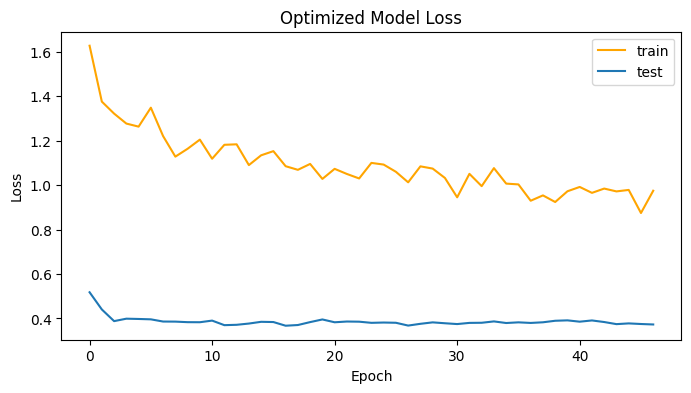

In [113]:
plt.figure(figsize=(8,4))
plt.plot(hist.history['loss'], color = 'orange')
plt.plot(hist.history['val_loss'])
plt.title('Optimized Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [114]:
#Se realiza prediccion
results = best_model.predict(X_test)

9/9 [==============================] - 0s 2ms/step


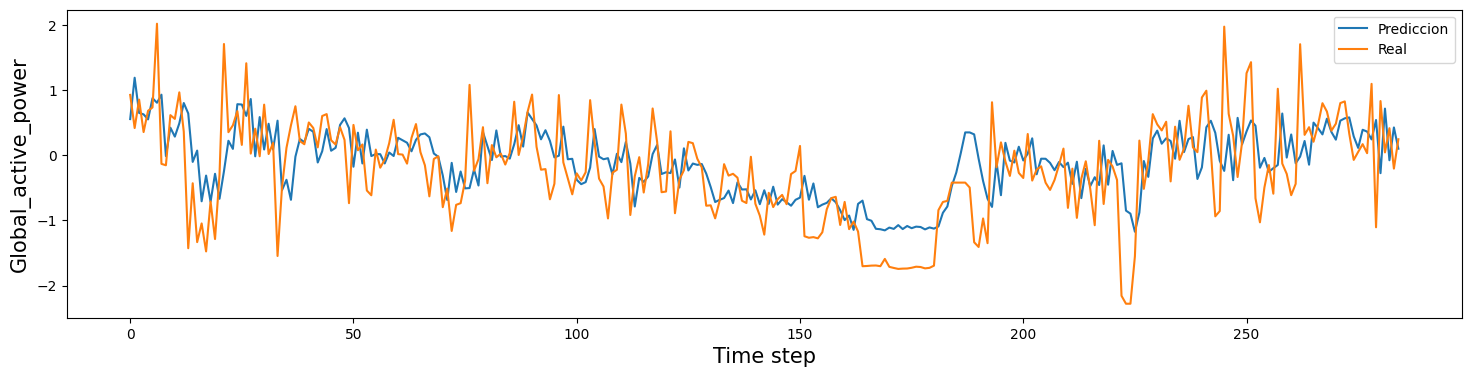

In [115]:
#Grafico de prediccion con el valor real
tiempo=[x for x in range(Y_test.shape[0])]
plt.figure(figsize=(18,4))
plt.plot(tiempo,results)
plt.ylabel('Global_active_power', size=15)
plt.plot(tiempo,Y_test)
plt.xlabel('Time step', size=15)
plt.legend(['Prediccion','Real'])
plt.show()

In [116]:
#Metricas de precision del modelo
score = best_model.evaluate(X_test, Y_test, verbose = 0)
print('MSE:', score[1])
print('RMSE:', score[2])
print('MAE:', score[3])
print('MAPE:', score[4])

MSE: 0.3986850380897522
RMSE: 0.631415069103241
MAE: 0.4776191711425781
MAPE: 218.63992309570312


#Exportar resultados

Se guardan los resultados la optimizacion bayesiana

In [117]:
#Del objeto all_results donde estan los resultados de cada trial de la optimizacion bayesiana se obtiene los parametros para exportalos a un csv
results=[]
trial=0 #Nº de intento de optimizacion bayesiana

for result in all_results:
  k=0 #validacion cruzada
  trial+=1
  i=0
  for time in result['time']:
    k+=1
    nameModel = "MLP_CE"+"_"+str(trial)+"_"+str(k) + "_"+str(result['params']['epochs'])+"_"+str(result['params']['batch_size'])+"_"+str(result['params']['layers'])+"_"+str(result['params']['neurons'])+"_"+str(round(result['params']['dropout'],2))+"_"+str(result['params']['optimizer'])+"_"+str(result['params']['learning_rate'])
    results.append([nameModel,trial,k,time,
                    result['scores_test'][i][0],result['scores_test'][i][2],result['scores_test'][i][3],result['scores_test'][i][4]]
                   )
    i+=1

In [118]:
#Se crea dataframe
results_csv=pd.DataFrame(results,columns=['nameModel','trial_optimizacion_bayesiana','Step_validacion','time','MSE','RMSE','MAE','MAPE'])


In [123]:
results_csv

,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
0,MLP_CE_1_1_800_80.0_2.0_576.0_0.54_adam_3.6215...,1,1,6.622234,0.477861,0.691275,0.532721,308.981506
1,MLP_CE_1_2_800_80.0_2.0_576.0_0.54_adam_3.6215...,1,2,4.680336,0.435825,0.660170,0.500538,251.917816
2,MLP_CE_1_3_800_80.0_2.0_576.0_0.54_adam_3.6215...,1,3,3.871634,0.435385,0.659837,0.495630,274.928467
3,MLP_CE_1_4_800_80.0_2.0_576.0_0.54_adam_3.6215...,1,4,4.476182,0.396603,0.629764,0.473172,219.708450
4,MLP_CE_1_5_800_80.0_2.0_576.0_0.54_adam_3.6215...,1,5,4.640783,0.395987,0.629275,0.472786,218.267105
5,MLP_CE_2_1_800_50.0_2.0_480.0_0.55_adam_3.9383...,2,1,9.453752,0.526662,0.725715,0.568334,335.718628
6,MLP_CE_2_2_800_50.0_2.0_480.0_0.55_adam_3.9383...,2,2,6.656345,0.441814,0.664691,0.508517,254.059296
7,MLP_CE_2_3_800_50.0_2.0_480.0_0.55_adam_3.9383...,2,3,4.639626,0.399519,0.632075,0.478493,245.475662
8,MLP_CE_2_4_800_50.0_2.0_480.0_0.55_adam_3.9383...,2,4,6.834982,0.392447,0.626456,0.467700,225.831161
9,MLP_CE_2_5_800_50.0_2.0_480.0_0.55_adam_3.9383...,2,5,5.948140,0.398685,0.631415,0.477619,218.639923


In [119]:
results_o = results_csv.sort_values(by='MSE', ascending=True)
results_o.head(5)

,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
8,MLP_CE_2_4_800_50.0_2.0_480.0_0.55_adam_3.9383...,2,4,6.834982,0.392447,0.626456,0.467700,225.831161
4,MLP_CE_1_5_800_80.0_2.0_576.0_0.54_adam_3.6215...,1,5,4.640783,0.395987,0.629275,0.472786,218.267105
3,MLP_CE_1_4_800_80.0_2.0_576.0_0.54_adam_3.6215...,1,4,4.476182,0.396603,0.629764,0.473172,219.708450
9,MLP_CE_2_5_800_50.0_2.0_480.0_0.55_adam_3.9383...,2,5,5.948140,0.398685,0.631415,0.477619,218.639923
7,MLP_CE_2_3_800_50.0_2.0_480.0_0.55_adam_3.9383...,2,3,4.639626,0.399519,0.632075,0.478493,245.475662


In [120]:
# Exportar el DataFrame como CSV
results_csv.to_csv('delete.csv')

Se guarda cada modelo keras en un objeto Json

In [121]:
import os
# Ruta de la carpeta que deseas crear
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos-2/delete'

# Verificar si la carpeta ya existe
if not os.path.exists(carpeta_destino):
    # Crear la carpeta si no existe
    os.makedirs(carpeta_destino)

In [122]:
#Del objeto all_results donde estan los resultados de cada trial de la optimizacion bayesiana se obtiene los modelos para exportalos a un Json
results=[]
trial=0 #Nº de intento de optimizacion bayesiana
for result in all_results:
  k=0 #validacion cruzada
  trial+=1
  i=0
  for model in result['models']:
    k+=1
    nameModel = "MLP_CE"+"_"+str(trial)+"_"+str(k) + "_"+str(result['params']['epochs'])+"_"+str(result['params']['batch_size'])+"_"+str(result['params']['layers'])+"_"+str(result['params']['neurons'])+"_"+str(round(result['params']['dropout'],2))+"_"+str(result['params']['optimizer'])+"_"+str(result['params']['learning_rate'])
    model_json = model.to_json()
    ruta = os.path.join(carpeta_destino, nameModel + ".json")
    with open(ruta, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    save_w=nameModel+"."+"h5"
    weights_path = os.path.join(carpeta_destino, save_w)
    model.save_weights(weights_path)
    i+=1